In [1]:
pip install casadi matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
# obstacle constraints

def get_rectangle_halfspace(x_center, y_center, width, height):
    # Axis-aligned rectangle
    A = np.array([[ 1, 0],
                  [-1, 0],
                  [0,  1],
                  [0, -1]])
    b = np.array([x_center + width/2,
                 -x_center + width/2,
                  y_center + height/2,
                 -y_center + height/2])
    return A, b

In [4]:
def get_rotated_rectangle_halfspace(x_center, y_center, width, height, theta):
    """
    Returns halfspace constraints (A, b) for a rotated rectangle.

    Parameters:
    - x_center, y_center: center of the rectangle
    - width, height: size of the rectangle (before rotation)
    - theta: rotation angle in radians (counterclockwise)

    Returns:
    - A, b such that A @ [x, y] <= b
    """
    # Define local (axis-aligned) normals
    A_local = np.array([[1, 0],
                        [-1, 0],
                        [0, 1],
                        [0, -1]])

    # Compute rotation matrix
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])

    # Rotate the normals
    A_rotated = A_local @ R.T  # Rotate normals (transpose because normals transform by inverse transpose)

    # Compute rotated rectangle vertices
    half_w, half_h = width / 2, height / 2
    corners = np.array([[ half_w,  half_h],
                        [-half_w,  half_h],
                        [-half_w, -half_h],
                        [ half_w, -half_h]])

    rotated_corners = (R @ corners.T).T + np.array([x_center, y_center])

    # For each normal, find the maximum dot product over the corners
    b = np.array([np.max(A_rotated[i] @ rotated_corners.T) for i in range(4)])

    return A_rotated, b

In [5]:
def rot_obs_trajectory(t_k, amp=-np.pi/4, omega=np.pi/2):
    return amp*(1-np.cos(omega*t_k))

In [6]:
def add_obca_constraints_opti(opti, X, S, LAMB, MU, A_list, b_list, ego_shape, dmin):
    """
    Adds OBCA-style obstacle avoidance constraints using ca.Opti().

    Parameters:
    - opti: casadi.Opti instance
    - X: Opti variable (4 x N+1) state trajectory
    - LAMB: Opti variable (total_m x N+1) dual variables for obstacle constraints
    - MU: Opti variable (4*n_obs x N+1) dual variables for ego shape
    - A_list: list of (m x 2) numpy arrays, halfspace normals for each obstacle
    - b_list: list of (m,) numpy arrays, halfspace offsets for each obstacle
    - ego_shape: array of 4 floats, g vector for ego (rectangle with 4 sides)
    - dmin: float, minimum distance
    """
    N = X.shape[1]
    n_obs = len(A_list)
    offset = (ego_shape[0]+ego_shape[2])/2 - ego_shape[2]
    # offset = ego_shape[0]

    g_obs = ca.DM(ego_shape)
    m_list = [A.shape[0] for A in A_list]
    cum_m = np.cumsum([0] + m_list)

    for k in range(N):
        theta_k = X[2, k]
        R = ca.vertcat(
            ca.horzcat(ca.cos(theta_k), -ca.sin(theta_k)),
            ca.horzcat(ca.sin(theta_k), ca.cos(theta_k))
        )

        xk = X[0, k]
        yk = X[1, k]
        t = ca.vertcat(xk + offset * ca.cos(theta_k),
                       yk + offset * ca.sin(theta_k))

        for j in range(n_obs):
            A = ca.DM(A_list[j])
            b = ca.DM(b_list[j])
            m = A.shape[0]
            lamb_jk = LAMB[cum_m[j]:cum_m[j+1], k]
            mu_jk = MU[4*j:4*(j+1), k]
            s_jk = S[cum_m[j]:cum_m[j + 1], k]

            # Constraint 1: norm(A^T * λ) ≤ 1
            norm_sq = ca.sumsqr(A.T @ lamb_jk)
            opti.subject_to(norm_sq == 1)

            # Constraint 2: G^T * μ + R^T * A^T * λ = 0
            G_mu = ca.vertcat(-mu_jk[0] + mu_jk[2],
                              -mu_jk[1] + mu_jk[3])
            AT_lambda = A.T @ lamb_jk
            dual_eq = G_mu + R.T @ AT_lambda
            opti.subject_to(dual_eq == 0)

            # Constraint 3: separation ≥ dmin
            A_t = A @ t
            sep = -ca.dot(g_obs, mu_jk) + ca.dot(A_t - b, lamb_jk)
            opti.subject_to(sep >= -s_jk)


In [7]:
def add_dyn_obca_constraints_opti(opti, X, S, LAMB_dyn, MU_dyn,n_obs, rot_obs, t_init,x_goal, ego_shape, dmin):

    N = X.shape[1]
    # n_obs = 1 #len(A_list)
    offset = (ego_shape[0]+ego_shape[2])/2 - ego_shape[2]
    # offset = ego_shape[0]

    g_obs = ca.DM(ego_shape)
    # m_list = [A.shape[0] for A in A_list]
    # cum_m = np.cumsum([0] + m_list)

    for k in range(N):
        A_list_dyn=[]
        b_list_dyn=[]
        t_k = k*dt+t_init
        rot_k = rot_obs_trajectory(t_k)
        A_dyn, b_dyn = get_rotated_rectangle_halfspace(*rot_obs, rot_k)
        A_list_dyn.append(A_dyn)
        b_list_dyn.append(b_dyn)
        A_list=A_list_dyn
        b_list=b_list_dyn

        m_list = [A.shape[0] for A in A_list]
        cum_m = np.cumsum([0] + m_list)

        theta_k = X[2, k]
        R = ca.vertcat(
            ca.horzcat(ca.cos(theta_k), -ca.sin(theta_k)),
            ca.horzcat(ca.sin(theta_k), ca.cos(theta_k))
        )

        xk = X[0, k]
        yk = X[1, k]
        t = ca.vertcat(xk + offset * ca.cos(theta_k),
                       yk + offset * ca.sin(theta_k))

        for j in range(n_obs):
            A = ca.DM(A_list[j])
            b = ca.DM(b_list[j])
            m = A.shape[0]
            lamb_jk = LAMB_dyn[cum_m[j]:cum_m[j+1], k]
            mu_jk = MU_dyn[4*j:4*(j+1), k]
            s_jk = S[cum_m[j]:cum_m[j + 1], k]

            # Constraint 1: norm(A^T * λ) ≤ 1
            norm_sq = ca.sumsqr(A.T @ lamb_jk)
            opti.subject_to(norm_sq == 1)

            # Constraint 2: G^T * μ + R^T * A^T * λ = 0
            G_mu = ca.vertcat(-mu_jk[0] + mu_jk[2],
                              -mu_jk[1] + mu_jk[3])
            AT_lambda = A.T @ lamb_jk
            dual_eq = G_mu + R.T @ AT_lambda
            opti.subject_to(dual_eq == 0)

            # Constraint 3: separation ≥ dmin
            A_t = A @ t
            sep = -ca.dot(g_obs, mu_jk) + ca.dot(A_t - b, lamb_jk)
            opti.subject_to(sep >= -s_jk)
            # print(sep)


In [8]:
# Dynamics
def f_dyn(x, u):
    xdot = x[3] * ca.cos(x[2])
    ydot = x[3] * ca.sin(x[2])
    thetadot = x[3] / L * ca.tan(u[1])
    vdot = u[0]
    return ca.vertcat(xdot, ydot, thetadot, vdot)

In [9]:
nx = 4 #state variale dimension -- x, y, theta, v
nu = 2 # control var dimension -- a, delta

# Vehicle model
L = 2
W = L/2

# Initial and final state
x_init = np.array([0.0, 0.0, 0.0, 0.0])
x_goal = np.array([9.0, -4.0, np.pi/2, 0.0])

# Time horizon and discretization
N = 80  # number of control intervals
# T = 10.0  # total time
dt = 0.1 #T / N
# T = N*dt

# Cost weights
# Q = np.diag([22, 22, 10, 20])
# # Qf = np.diag([100, 100, 50, 50])
# Qf = np.diag([40, 40, 10, 20])
Q = np.diag([22, 22, 40, 20])
# Qf = np.diag([100, 100, 50, 50])
Qf = np.diag([40, 40, 40, 20])
R = np.diag([0.1, 0.1])

kappa =10000 # slack variable weight

In [10]:
# Define obstacles
obstacles = [
    (4, -4, 8, 3),   # (x_center, y_center, width, height)
    (14, -4, 8, 3)
]
A_obs1, b_obs1 = get_rectangle_halfspace(*obstacles[0])
A_obs2, b_obs2 = get_rectangle_halfspace(*obstacles[1])
A_list = [A_obs1, A_obs2]
b_list = [b_obs1, b_obs2]

# total_m = sum(A.shape[0] for A in A_list)
n_obs_static = len(A_list) #1 obstacle
total_m = sum(A.shape[0] for A in A_list)

n_obs_dyn = 1
total_m_dyn= A_list[0].shape[0]
w_rot_obs = 0.2
l_rot_obs = 4+w_rot_obs
rot_obs = [10+w_rot_obs/2, -2.5, l_rot_obs, w_rot_obs]

In [11]:
# Bounds on states and control
v_min, v_max = -2.0, 2.0
a_min, a_max = -1.0, 1.0
delta_min, delta_max = -1, 1

In [12]:
# Solver setup
opts = {
    'ipopt': {
        'print_level': 0,
        'max_iter': 500,
        'tol': 1e-6,
        'acceptable_tol': 1e-4,
        'print_timing_statistics': 'no',
        'warm_start_init_point': 'yes',
        'sb': 'yes'
    },
    'print_time': False
}

In [13]:
# Parameters
N_sim = 2*N
T=N_sim*dt                     # Total number of MPC steps
x_curr = x_init.copy()         # Start from initial state
X_hist = [x_curr]              # For storing state trajectory
U_hist = []                    # For storing applied controls

start_time = time.time()
for sim_step in range(N_sim):
    t_sim= dt * sim_step
    print(f"Simulation step {sim_step+1}/{N_sim}")
    opti = ca.Opti()

    # Decision variables
    X = opti.variable(nx, N+1)
    U = opti.variable(nu, N)
    LAMB = opti.variable(total_m, N+1)
    MU = opti.variable(nx * len(A_list), N+1)
    LAMB_dyn = opti.variable(total_m_dyn, N+1)
    MU_dyn   = opti.variable(nx * n_obs_dyn, N+1)
    s = opti.variable(total_m, N+1)
    s_dyn = opti.variable(total_m_dyn, N+1)

    # Cost
    cost = 0
    for k in range(N):
        cost += ca.mtimes((X[:,k] - x_goal).T, Q @ (X[:,k] - x_goal))
        cost += ca.mtimes(U[:,k].T,R @ U[:,k])
        cost += kappa * ca.sum1(s[:,k]) # slack variable cost
        cost += kappa * ca.sum1(s_dyn[:,k]) # slack variable cost
    # soft terminal constraint imposition through terminal cost
    cost += ca.mtimes((X[:,N] - x_goal).T, Qf @ (X[:,N] - x_goal))
    opti.minimize(cost)

    # Bounds
    for k in range(N+1):
        opti.subject_to(X[3,k] >= v_min)
        opti.subject_to(X[3,k] <= v_max)
    for k in range(N):
        opti.subject_to(U[0,k] >= a_min)
        opti.subject_to(U[0,k] <= a_max)
        opti.subject_to(U[1,k] >= delta_min)
        opti.subject_to(U[1,k] <= delta_max)

    # Dynamics
    for k in range(N):
        x_next = X[:,k] + dt * f_dyn(X[:,k], U[:,k])
        opti.subject_to(X[:,k+1] == x_next)

    # Initial condition
    opti.subject_to(X[:,0] == x_curr)
    # (Optional) hard terminal constraint imposition in last iter (may make the optimization infeasible)
    # if sim_step == N_sim - 1:
        # opti.subject_to(X[:, -1] == x_goal)

    # OBCA constraints
    add_obca_constraints_opti(opti, X,s, LAMB, MU, A_list, b_list,
                               ego_shape=[L/2, W/2, L/2, W/2], dmin=0.3)
    add_dyn_obca_constraints_opti(opti, X,s_dyn, LAMB_dyn, MU_dyn, n_obs_dyn, rot_obs, t_sim,x_goal, ego_shape=[L/2, W/2, L/2, W/2], dmin=0.3)

    opti.subject_to(ca.vec(LAMB) >= 0)
    opti.subject_to(ca.vec(MU) >= 0)
    opti.subject_to(ca.vec(LAMB_dyn) >= 0)
    opti.subject_to(ca.vec(MU_dyn) >= 0)
    opti.subject_to(ca.vec(s) >= 0)
    opti.subject_to(ca.vec(s_dyn) >= 0)

    # Initial guess
    if sim_step > 0:
        x_guess = np.hstack([X_prev[:,1:], X_prev[:,-1:]])
        u_guess = np.hstack([U_prev[:,1:], U_prev[:,-1:]])
    else:
        x_guess = np.tile(x_curr.reshape(-1, 1), (1, N+1))
        u_guess = np.zeros((2, N))

    opti.set_initial(X, x_guess)
    opti.set_initial(U, u_guess)

    # Solver
    opti.solver('ipopt', opts)

    try:
        sol = opti.solve()
        u_apply = sol.value(U)[:, 0]                    # First control
        x_next = x_curr + dt * f_dyn(x_curr, u_apply)   # Forward simulate

        # Extract predicted trajectories for warm start
        X_prev = sol.value(X)
        U_prev = sol.value(U)

        # Store
        U_hist.append(u_apply)
        X_hist.append(x_next.full().flatten())

        # Update state
        x_curr = x_next.full().flatten()

    except RuntimeError as e:
        print(f"MPC failed at step {sim_step}: {e}")
        print("x_curr =", x_curr)
        try:
            print("Last known guess for control:", opti.debug.value(U)[:, 0])
        except:
            print("Failed to retrieve debug values.")
        break
end_time = time.time()
print(f"Elapsed time: {end_time - start_time:.6f} seconds")

Simulation step 1/160
Simulation step 2/160
Simulation step 3/160
Simulation step 4/160
Simulation step 5/160
Simulation step 6/160
Simulation step 7/160
Simulation step 8/160
Simulation step 9/160
Simulation step 10/160
Simulation step 11/160
Simulation step 12/160
Simulation step 13/160
Simulation step 14/160
Simulation step 15/160
Simulation step 16/160
Simulation step 17/160
Simulation step 18/160
Simulation step 19/160
Simulation step 20/160
Simulation step 21/160
Simulation step 22/160
Simulation step 23/160
Simulation step 24/160
Simulation step 25/160
Simulation step 26/160
Simulation step 27/160
Simulation step 28/160
Simulation step 29/160
Simulation step 30/160
Simulation step 31/160
Simulation step 32/160
Simulation step 33/160
Simulation step 34/160
Simulation step 35/160
Simulation step 36/160
Simulation step 37/160
Simulation step 38/160
Simulation step 39/160
Simulation step 40/160
Simulation step 41/160
Simulation step 42/160
Simulation step 43/160
Simulation step 44/1

In [14]:
def plot_rotated_rectangle_fixed(x_center, y_center, width, height, theta, ax):
    # fig, ax = plt.subplots()
    ax.set_aspect('equal')

    # Rotation matrix
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])

    # Rectangle corners (local coordinates)
    half_w, half_h = width / 2, height / 2
    corners = np.array([[ half_w,  half_h],
                        [-half_w,  half_h],
                        [-half_w, -half_h],
                        [ half_w, -half_h]])

    # Rotate and shift to center
    rotated_corners = (R @ corners.T).T + np.array([x_center, y_center])
    rotated_corners = np.vstack((rotated_corners, rotated_corners[0]))  # Close the loop

    # Plot the rotated rectangle
    ax.plot(rotated_corners[:,0], rotated_corners[:,1], 'r-', linewidth=2)
    ax.plot(x_center, y_center, 'bo')
    ax.set_xlim(x_center - width * 2, x_center + width * 2)
    ax.set_ylim(y_center - height * 2, y_center + height * 2)
    # ax.set_title(f'Rotated Rectangle (angle = {np.degrees(theta):.1f}°)')
    ax.legend()

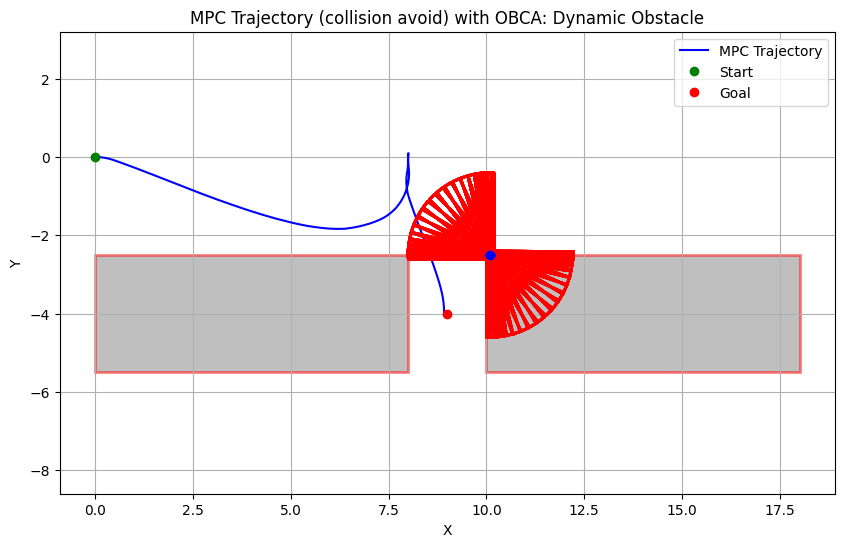

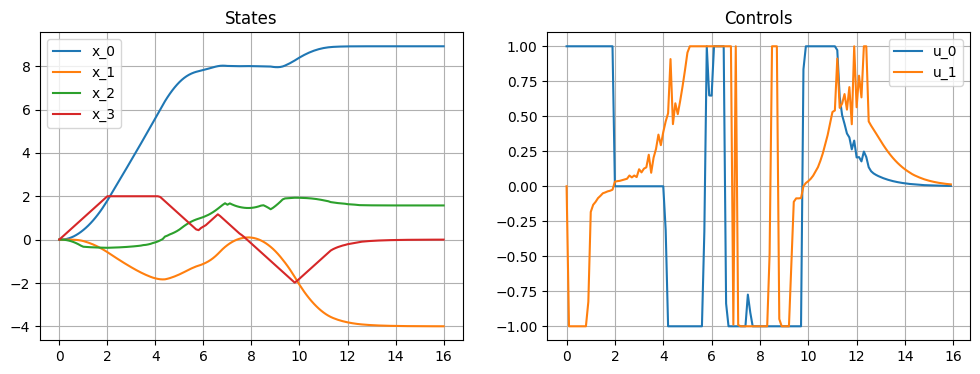

In [15]:
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.cm as cm

X_mpc = np.array(X_hist).T
U_mpc = np.array(U_hist).T
T=N_sim*dt
# t_eval_mpc = np.arange(0, dt * X_mpc.shape[1], dt)
t_eval_mpc = np.linspace(0, N_sim*dt, N_sim+1)

# Trajectory plot
plt.figure(figsize=(10, 6))
plt.plot(X_mpc[0, :], X_mpc[1, :], 'b-', label='MPC Trajectory')
plt.plot(x_init[0], x_init[1], 'go', label='Start')
plt.plot(x_goal[0], x_goal[1], 'ro', label='Goal')
for obs in obstacles:
    x_c, y_c, w, h = obs
    rect = Rectangle((x_c - w/2, y_c - h/2), w, h,
                             linewidth=2, edgecolor='red', facecolor='gray', alpha=0.5)
    plt.gca().add_patch(rect)

# Define colormap and normalize over [0, T]
cmap = cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=T)

# Plot dynamic obstacle at several time steps
for k in range(0, N_sim+1):# [0, N]: #range(0, N+1):  # every 5 time steps
    t_k = k * dt
    rot_k = rot_obs_trajectory(t_k)

    color = cmap(norm(t_k))  # get color based on time

    plot_rotated_rectangle_fixed(rot_obs[0], rot_obs[1], rot_obs[2], rot_obs[3], rot_k, plt.gca())
    # plt.gca().add_patch(rect_dyn)

plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.axis("equal")
plt.title("MPC Trajectory (collision avoid) with OBCA: Dynamic Obstacle")
plt.legend()
plt.show()

# State + Control time series
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(nx):
    plt.plot(t_eval_mpc, X_mpc[i, :], label=f"x_{i}")
plt.legend(); plt.title("States")
plt.grid()

plt.subplot(1, 2, 2)
for i in range(nu):
    plt.plot(t_eval_mpc[:-1], U_mpc[i, :], label=f"u_{i}")
plt.legend(); plt.title("Controls")
plt.grid()
plt.show()


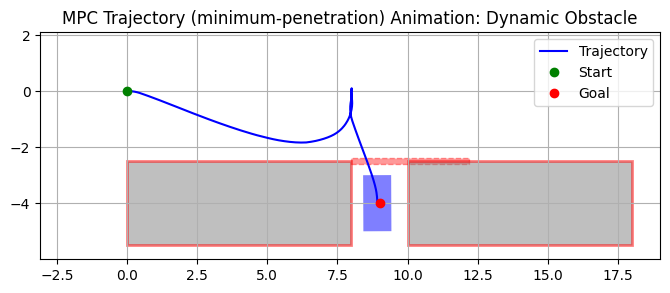

In [16]:
## Animation

# Car dimensions
car_length = L
car_width = W

# Set up figure
fig, ax = plt.subplots(figsize=(8, 8))
# ax.set_xlim(np.min(X_mpc[0, :]) - 2, np.max(X_mpc[0, :]) + 2)
ax.set_ylim(np.min(X_mpc[1, :]) - 2, np.max(X_mpc[1, :]) + 2)
ax.set_aspect('equal')
ax.grid(True)
ax.set_title("MPC Trajectory (minimum-penetration) Animation: Dynamic Obstacle")

# Initialize plot elements
trajectory_line, = ax.plot([], [], 'b-', label='Trajectory')
start_point = ax.plot(x_init[0], x_init[1], 'go', label='Start')[0]
goal_point = ax.plot(x_goal[0], x_goal[1], 'ro', label='Goal')[0]

# Car rectangle initialized at (0, 0) relative to its own frame
car_patch = Rectangle((-car_length / 2, -car_width / 2), car_length, car_width,
                      facecolor='blue', alpha=0.5)
ax.add_patch(car_patch)

# Dynamic obstacle patch (initially placed at 0,0; updated later)
dyn_obs_patch = Rectangle((-rot_obs[2]/2, -rot_obs[3]/2), rot_obs[2], rot_obs[3],
                      facecolor='red', alpha=0.4, linestyle='--', edgecolor='red')
ax.add_patch(dyn_obs_patch)

# Plot static obstacles
for obs in obstacles:
    x_c, y_c, w, h = obs
    rect = Rectangle((x_c - w/2, y_c - h/2), w, h,
                     linewidth=2, edgecolor='red', facecolor='gray', alpha=0.5)
    ax.add_patch(rect)
ax.legend()

# Animation update function
def update(frame):
    x, y, theta = X_mpc[0, frame], X_mpc[1, frame], X_mpc[2, frame]

    # Update trajectory line
    trajectory_line.set_data(X_mpc[0, :frame+1], X_mpc[1, :frame+1])

    # Rotate and translate car patch
    transform = Affine2D().rotate(theta).translate(x, y) + ax.transData
    car_patch.set_transform(transform)

    # Update dynamic obstacle (rotating rectangle)
    t_k = frame * dt
    rot_k = rot_obs_trajectory(t_k)

    transform = Affine2D().rotate(rot_k).translate(rot_obs[0], rot_obs[1]) + ax.transData
    dyn_obs_patch.set_transform(transform)


    return trajectory_line, car_patch, dyn_obs_patch

# Animate
ani = animation.FuncAnimation(fig, update, frames=X_mpc.shape[1], interval=100, blit=True)

# Save to file
ani.save("mpc_trajectory_dynobs_rot.gif", writer='pillow', fps=10)

plt.show()


/var/folders/z0/3frv2l990hb5ryd49z8vm4w80000gn/T/ipykernel_6319/2956996658.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


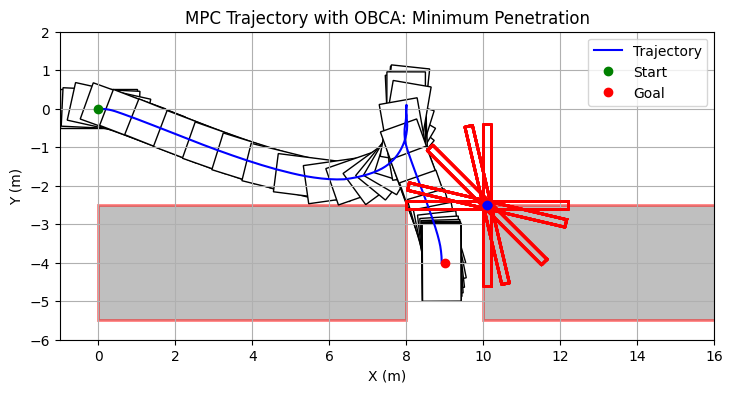

In [17]:


# --- Merged static and dynamic obstacle trajectory plot ---
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(X_mpc[0, :], X_mpc[1, :], 'b-', label='Trajectory')
ax.plot(x_init[0], x_init[1], 'go', label='Start')
ax.plot(x_goal[0], x_goal[1], 'ro', label='Goal')

# Static obstacles
for obs in obstacles:
    x_c, y_c, w, h = obs
    rect = Rectangle((x_c - w/2, y_c - h/2), w, h,
                     linewidth=2, edgecolor='red', facecolor='gray', alpha=0.5)
    ax.add_patch(rect)

# Vehicle shape visualization every few steps
for i in range(0,N_sim+1, 4):
    veh_pose = Rectangle((X_mpc[0, i] - L/2, X_mpc[1, i] - W/2), L, W,
                         facecolor='white', edgecolor='black', alpha=1)
    trans = Affine2D().rotate_deg_around(X_mpc[0, i], X_mpc[1, i], np.rad2deg(X_mpc[2, i])) + ax.transData
    veh_pose.set_transform(trans)
    ax.add_patch(veh_pose)

# Dynamic obstacle trajectory visualization
from matplotlib import cm
from matplotlib.colors import Normalize

norm = Normalize(vmin=0, vmax=N_sim * dt)
cmap = cm.get_cmap('viridis')

for k in range(0, N_sim+1, 5):  # every 10 time steps
    t_k = k * dt
    rot_k = rot_obs_trajectory(t_k)

    color = cmap(norm(t_k))  # get color based on time

    plot_rotated_rectangle_fixed(rot_obs[0], rot_obs[1], rot_obs[2], rot_obs[3], rot_k, plt.gca())

# Final plot settings
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_ylim(-6, 2)
ax.set_xlim(-1, 16)
ax.grid(True)
ax.set_aspect('equal')
ax.set_title("MPC Trajectory with OBCA: Minimum Penetration")
ax.legend()
plt.show()
fig.clf()
plt.close(fig)